In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [7]:
# Load the data
matches = pd.read_csv('matches.csv')

# Drop rows with no result
matches = matches.dropna(subset=['winner'])

data = matches[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'winner']].copy()



In [9]:
# Keep necessary columns and make a copy to avoid SettingWithCopyWarning
data = matches[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'winner']].copy()

# Encode teams and winner
teams = pd.concat([data['team1'], data['team2'], data['toss_winner'], data['winner']])
team_encoder = LabelEncoder()
team_encoder.fit(teams)

data['team1'] = team_encoder.transform(data['team1'])
data['team2'] = team_encoder.transform(data['team2'])
data['toss_winner'] = team_encoder.transform(data['toss_winner'])
data['winner'] = team_encoder.transform(data['winner'])

# Encode toss decision
data['toss_decision'] = data['toss_decision'].map({'bat': 0, 'field': 1})

# Encode venue
data['venue'] = LabelEncoder().fit_transform(data['venue'])


In [11]:
X = data[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue']]
y = data['winner']


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [19]:
# Predict
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# Classification report
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))


Logistic Regression Accuracy: 0.2251655629139073
Random Forest Accuracy: 0.4900662251655629
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.72      0.60        18
           1       0.25      0.12      0.17         8
           2       0.50      0.20      0.29         5
           3       0.45      0.38      0.42        13
           4       1.00      0.50      0.67         2
           5       0.37      0.41      0.39        17
           6       0.00      0.00      0.00         1
           7       0.52      0.62      0.57        21
           8       0.43      0.50      0.46        18
           9       0.00      0.00      0.00         1
          10       0.75      0.45      0.56        20
          11       1.00      0.50      0.67         2
          12       1.00      1.00      1.00         1
          13       0.36      0.33      0.34        15
          14       0.62      0.89      0.73         9

    

In [21]:
try:
    import xgboost
    print("✅ XGBoost is installed.")
except ImportError:
    print("❌ XGBoost is NOT installed.")


✅ XGBoost is installed.


In [25]:
from xgboost import XGBClassifier

# Old (causes warning):
# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# ✅ New (recommended):
model = XGBClassifier(eval_metric='mlogloss', random_state=42)


In [29]:
xgb_preds = model.predict(X_test)


In [31]:
from sklearn.metrics import accuracy_score, classification_report

print("✅ XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("\n📊 Classification Report:\n", classification_report(y_test, xgb_preds))


✅ XGBoost Accuracy: 0.5496688741721855

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57        18
           1       0.40      0.25      0.31         8
           2       0.67      0.40      0.50         5
           3       0.46      0.46      0.46        13
           4       1.00      0.50      0.67         2
           5       0.47      0.41      0.44        17
           6       0.00      0.00      0.00         1
           7       0.64      0.67      0.65        21
           8       0.56      0.56      0.56        18
           9       0.00      0.00      0.00         1
          10       0.75      0.60      0.67        20
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          13       0.38      0.40      0.39        15
          14       0.73      0.89      0.80         9

    accuracy                           0.55       151
   macro avg  

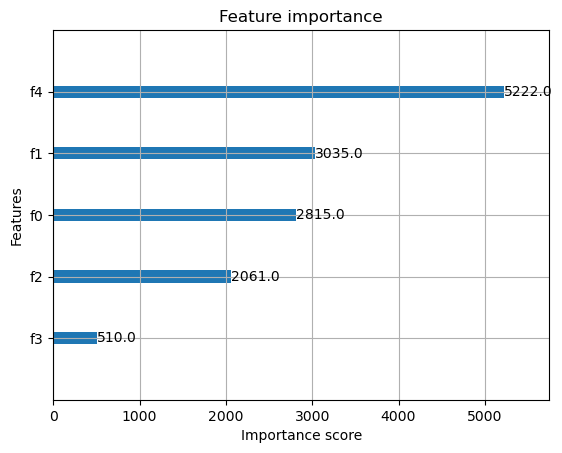

In [33]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.show()


In [35]:
batting_stats = pd.read_csv('most_runs_average_strikerate.csv')
batting_stats.columns = batting_stats.columns.str.lower()

# Check structure
print(batting_stats.head())


     batsman  total_runs  out  numberofballs    average  strikerate
0    V Kohli        5426  152           4111  35.697368  131.987351
1   SK Raina        5386  160           3916  33.662500  137.538304
2  RG Sharma        4902  161           3742  30.447205  130.999466
3  DA Warner        4717  114           3292  41.377193  143.286756
4   S Dhawan        4601  137           3665  33.583942  125.538881


In [37]:
deliveries = pd.read_csv('deliveries.csv')

# Get a mapping of players to batting teams
player_team_map = deliveries[['batsman', 'batting_team']].drop_duplicates()


In [39]:
# Merge player stats with the teams they played for
batting_with_team = pd.merge(batting_stats, player_team_map, left_on='batsman', right_on='batsman')

# Clean team names if needed (trim spaces, handle IPL name changes)
batting_with_team['batting_team'] = batting_with_team['batting_team'].str.strip()


In [41]:
# Group by team and take average strikerate (can also use average or total_runs)
team_batting_strength = batting_with_team.groupby('batting_team')['strikerate'].mean().reset_index()

# Rename for clarity
team_batting_strength = team_batting_strength.rename(columns={
    'batting_team': 'team_name',
    'strikerate': 'batting_strength'
})


In [43]:
# Encode team names to match those in model dataset
team_batting_strength['team'] = team_encoder.transform(team_batting_strength['team_name'])

# Merge into model data for both team1 and team2
data = data.merge(team_batting_strength[['team', 'batting_strength']], left_on='team1', right_on='team', how='left')
data = data.rename(columns={'batting_strength': 'team1_batting_strength'})
data.drop('team', axis=1, inplace=True)

data = data.merge(team_batting_strength[['team', 'batting_strength']], left_on='team2', right_on='team', how='left')
data = data.rename(columns={'batting_strength': 'team2_batting_strength'})
data.drop('team', axis=1, inplace=True)


In [47]:
print(data.columns.tolist())


['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'winner', 'team1_batting_strength', 'team2_batting_strength']


In [49]:
home_away = pd.read_csv('teamwise_home_and_away.csv')
home_away.columns = home_away.columns.str.lower()


In [51]:
home_away['team'] = home_away['team'].str.strip()  # clean spaces
home_away['team'] = team_encoder.transform(home_away['team'])  # use same encoder


In [53]:
# Merge home win % for team1
data = data.merge(
    home_away[['team', 'home_win_percentage']].rename(columns={
        'team': 'team1', 'home_win_percentage': 'team1_home_win_pct'
    }),
    on='team1',
    how='left'
)

# Merge away win % for team2
data = data.merge(
    home_away[['team', 'away_win_percentage']].rename(columns={
        'team': 'team2', 'away_win_percentage': 'team2_away_win_pct'
    }),
    on='team2',
    how='left'
)


In [55]:
print(data.columns.tolist())


['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'winner', 'team1_batting_strength', 'team2_batting_strength', 'team1_home_win_pct', 'team2_away_win_pct']


In [57]:
X = data[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue',
          'team1_home_win_pct', 'team2_away_win_pct',
          'team1_batting_strength', 'team2_batting_strength']]
y = data['winner']


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, preds))


✅ Accuracy: 0.543046357615894


In [61]:
# Reverse the label encoding to get team names
predicted_team_names = team_encoder.inverse_transform(preds)

# Print a few examples
print("🔮 Predicted Winning Teams:")
print(predicted_team_names[:10])


🔮 Predicted Winning Teams:
['Sunrisers Hyderabad' 'Royal Challengers Bangalore'
 'Royal Challengers Bangalore' 'Rajasthan Royals' 'Kolkata Knight Riders'
 'Rajasthan Royals' 'Mumbai Indians' 'Kolkata Knight Riders'
 'Chennai Super Kings' 'Mumbai Indians']


In [63]:
pred = model.predict(X_test)


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load the matches data
data = pd.read_csv("matches.csv")

# Keep only required columns
data = data[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'winner']]

# Drop rows with missing values
data.dropna(inplace=True)

# Fit team encoder on all team-related columns
team_encoder = LabelEncoder()
team_encoder.fit(
    pd.concat([data['team1'], data['team2'], data['toss_winner'], data['winner']])
)

# Fit venue encoder
venue_encoder = LabelEncoder()
venue_encoder.fit(data['venue'])

# Encode the columns
data['team1'] = team_encoder.transform(data['team1'])
data['team2'] = team_encoder.transform(data['team2'])
data['toss_winner'] = team_encoder.transform(data['toss_winner'])
data['winner'] = team_encoder.transform(data['winner'])
data['toss_decision'] = data['toss_decision'].map({'bat': 0, 'field': 1})
data['venue'] = venue_encoder.transform(data['venue'])

# Dummy team strength and win percentage values (replace with real data if you have)
team_batting_strength = pd.DataFrame({
    'team': data['team1'].unique(),
    'batting_strength': [130]*len(data['team1'].unique())
})

home_away = pd.DataFrame({
    'team': data['team1'].unique(),
    'home_win_percentage': [50]*len(data['team1'].unique()),
    'away_win_percentage': [50]*len(data['team1'].unique())
})

# Add dummy strength columns to the main data for training
data['team1_batting_strength'] = 130
data['team2_batting_strength'] = 130
data['team1_home_win_pct'] = 50
data['team2_away_win_pct'] = 50

# Split and train model
X = data[['team1', 'team2', 'toss_winner', 'toss_decision', 'venue',
          'team1_home_win_pct', 'team2_away_win_pct',
          'team1_batting_strength', 'team2_batting_strength']]
y = data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = XGBClassifier(eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
def predict_winner(team1, team2, toss_winner, toss_decision, venue):
    team_aliases = {
        'MI': 'Mumbai Indians',
        'RCB': 'Royal Challengers Bangalore',
        'CSK': 'Chennai Super Kings',
        'DC': 'Delhi Capitals',
        'KKR': 'Kolkata Knight Riders',
        'SRH': 'Sunrisers Hyderabad',
        'GT': 'Gujarat Titans',
        'LSG': 'Lucknow Super Giants',
        'RR': 'Rajasthan Royals',
        'PBKS': 'Punjab Kings',
    }

    team1 = team_aliases.get(team1, team1)
    team2 = team_aliases.get(team2, team2)
    toss_winner = team_aliases.get(toss_winner, toss_winner)

    t1 = team_encoder.transform([team1])[0]
    t2 = team_encoder.transform([team2])[0]
    toss = team_encoder.transform([toss_winner])[0]
    toss_dec = 0 if toss_decision == 'bat' else 1

    if venue not in venue_encoder.classes_:
        raise ValueError(f"❌ Unknown venue: '{venue}'. Must be one of: {list(venue_encoder.classes_)}")
    venue_encoded = venue_encoder.transform([venue])[0]

    t1_bat = 130
    t2_bat = 130
    t1_home = 50
    t2_away = 50

    input_df = pd.DataFrame([[
        t1, t2, toss, toss_dec, venue_encoded,
        t1_home, t2_away,
        t1_bat, t2_bat
    ]], columns=[
        'team1', 'team2', 'toss_winner', 'toss_decision', 'venue',
        'team1_home_win_pct', 'team2_away_win_pct',
        'team1_batting_strength', 'team2_batting_strength'
    ])

    pred_label = model.predict(input_df)[0]
    pred_team_name = team_encoder.inverse_transform([pred_label])[0]
    proba = model.predict_proba(input_df)[0]
    confidence = round(100 * proba[pred_label], 2)

    return pred_team_name, confidence
s

In [19]:
team, conf = predict_winner('MI', 'RCB', 'RCB', 'field', 'Wankhede Stadium')
print(f"🏆 Predicted Winner: {team} with {conf}% confidence")


🏆 Predicted Winner: Mumbai Indians with 51.48% confidence


In [21]:
import pickle

# Save model
pickle.dump(model, open('xgb_model.pkl', 'wb'))

# Save encoders
pickle.dump(team_encoder, open('team_encoder.pkl', 'wb'))
pickle.dump(venue_encoder, open('venue_encoder.pkl', 'wb'))

# Save team strength data if you used it as a DataFrame
team_batting_strength.to_csv('team_batting_strength.csv', index=False)
home_away.to_csv('home_away.csv', index=False)
